# EV DoS Attack - Charging Diagnostic Analysis
**Goal**: Diagnose why `is_charging` column is 0 in the Toy_DoS CSV output.  
**Data**: `results/Toy_DoS_ev0.csv`, `Toy_DoS_ev1.csv`, `Toy_DoS_cs0.csv`, `Toy_DoS_rsu0.csv`

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load all CSVs
results_dir = 'results'
ev0 = pd.read_csv(os.path.join(results_dir, 'Toy_DoS_ev0.csv'))
ev1 = pd.read_csv(os.path.join(results_dir, 'Toy_DoS_ev1.csv'))
cs0 = pd.read_csv(os.path.join(results_dir, 'Toy_DoS_cs0.csv'))
rsu0 = pd.read_csv(os.path.join(results_dir, 'Toy_DoS_rsu0.csv'))

print(f"ev0: {len(ev0)} rows, time range [{ev0.timestamp.min():.1f}, {ev0.timestamp.max():.1f}]s")
print(f"ev1: {len(ev1)} rows, time range [{ev1.timestamp.min():.1f}, {ev1.timestamp.max():.1f}]s")
print(f"cs0: {len(cs0)} rows")
print(f"rsu0: {len(rsu0)} rows")

ev0: 6558 rows, time range [6.4, 299.6]s
ev1: 1090 rows, time range [15.5, 299.6]s
cs0: 6513 rows
rsu0: 981 rows


## 1. Basic Stats: SoC Range and Charging Events

In [12]:
# Stats for each EV
for name, df in [('ev0 (attacker)', ev0), ('ev1 (normal)', ev1)]:
    charging_rows = df[df['is_charging'] == 1]
    charge_req = df[df['communication_type'] == 'ChargeReq']
    charge_start = df[df['event_type'] == 'CHARGE_START']
    charge_end = df[df['event_type'] == 'CHARGE_END']
    charging_ticks = df[df['event_type'] == 'CHARGING']

    print(f"\n=== {name} ===")
    print(f"  SoC range:       [{df.soc.min():.4f}, {df.soc.max():.4f}]  ({df.soc.min()*100:.1f}% to {df.soc.max()*100:.1f}%)")
    print(f"  Battery range:   [{df.battery_level.min():.1f}, {df.battery_level.max():.1f}] Wh")
    print(f"  is_charging=1:   {len(charging_rows)} rows")
    print(f"  ChargeReq sent:  {len(charge_req)} rows")
    print(f"  CHARGE_START:    {len(charge_start)} events")
    print(f"  CHARGING ticks:  {len(charging_ticks)} events")
    print(f"  CHARGE_END:      {len(charge_end)} events")

    if len(charge_req) > 0:
        first_req = charge_req.iloc[0]
        print(f"  First ChargeReq: t={first_req.timestamp:.1f}s, SoC={first_req.soc:.4f}, pos=({first_req.pos_x:.0f},{first_req.pos_y:.0f})")


=== ev0 (attacker) ===
  SoC range:       [0.1942, 1.0000]  (19.4% to 100.0%)
  Battery range:   [38.8, 200.0] Wh
  is_charging=1:   378 rows
  ChargeReq sent:  2 rows
  CHARGE_START:    1 events
  CHARGING ticks:  82 events
  CHARGE_END:      1 events
  First ChargeReq: t=106.1s, SoC=0.1942, pos=(192,223)

=== ev1 (normal) ===
  SoC range:       [0.1934, 1.0000]  (19.3% to 100.0%)
  Battery range:   [38.7, 200.0] Wh
  is_charging=1:   359 rows
  ChargeReq sent:  40 rows
  CHARGE_START:    1 events
  CHARGING ticks:  81 events
  CHARGE_END:      1 events
  First ChargeReq: t=116.1s, SoC=0.1977, pos=(40,427)


## 2. SoC Over Time (Both EVs)

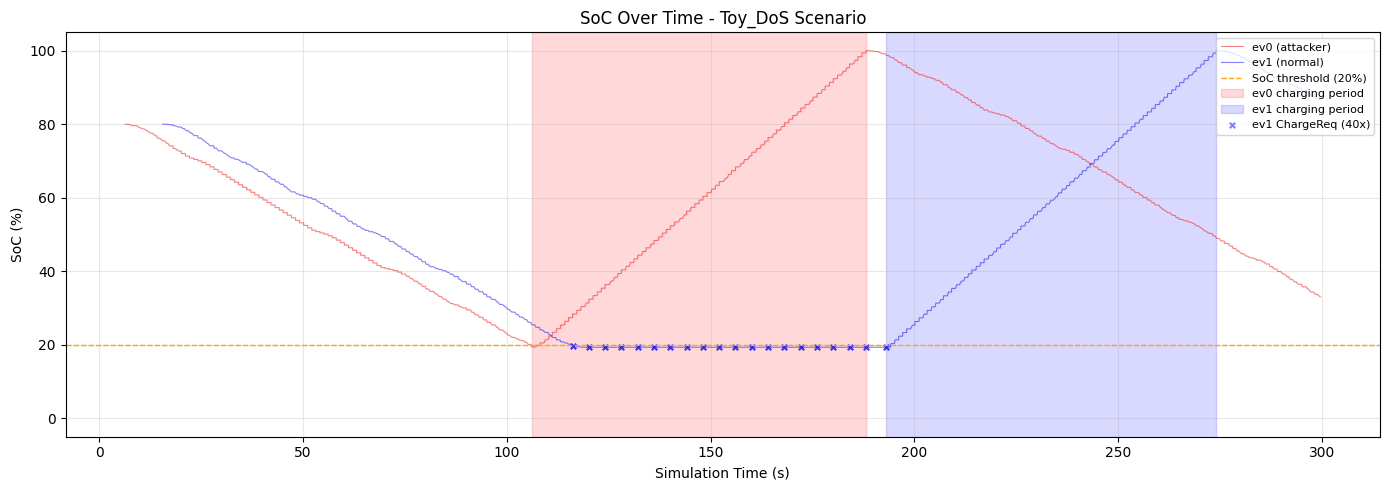

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(ev0.timestamp, ev0.soc * 100, 'r-', alpha=0.5, linewidth=0.8, label='ev0 (attacker)')
ax.plot(ev1.timestamp, ev1.soc * 100, 'b-', alpha=0.5, linewidth=0.8, label='ev1 (normal)')

# Mark charging threshold
ax.axhline(y=20, color='orange', linestyle='--', linewidth=1, label='SoC threshold (20%)')

# Mark charging events for ev0
ev0_charging = ev0[ev0['is_charging'] == 1]
if len(ev0_charging) > 0:
    ax.axvspan(ev0_charging.timestamp.min(), ev0_charging.timestamp.max(),
               alpha=0.15, color='red', label='ev0 charging period')

# Mark charging events for ev1
ev1_charging = ev1[ev1['is_charging'] == 1]
if len(ev1_charging) > 0:
    ax.axvspan(ev1_charging.timestamp.min(), ev1_charging.timestamp.max(),
               alpha=0.15, color='blue', label='ev1 charging period')

# Mark ChargeReq events for ev1
ev1_req = ev1[ev1['communication_type'] == 'ChargeReq']
if len(ev1_req) > 0:
    ax.scatter(ev1_req.timestamp, ev1_req.soc * 100, marker='x', color='blue',
              s=15, alpha=0.5, label=f'ev1 ChargeReq ({len(ev1_req)}x)')

ax.set_xlabel('Simulation Time (s)')
ax.set_ylabel('SoC (%)')
ax.set_title('SoC Over Time - Toy_DoS Scenario')
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(-5, 105)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Distance to CS Over Time
CS is at position (200, 200). Charging range = 300m.

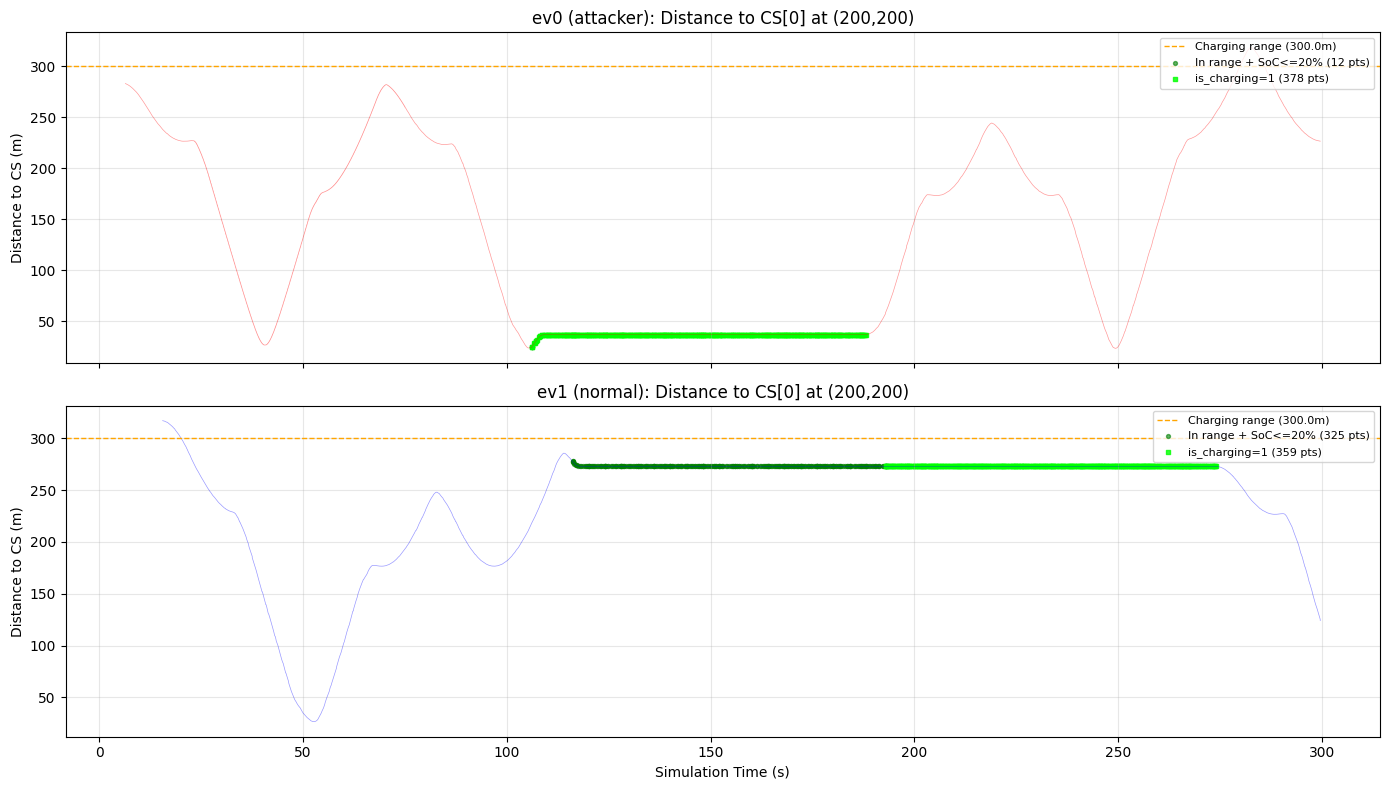

In [14]:
CS_X, CS_Y = 200.0, 200.0
CHARGE_RANGE = 300.0

ev0['dist_to_cs'] = np.sqrt((ev0.pos_x - CS_X)**2 + (ev0.pos_y - CS_Y)**2)
ev1['dist_to_cs'] = np.sqrt((ev1.pos_x - CS_X)**2 + (ev1.pos_y - CS_Y)**2)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, name, df, color in [(axes[0], 'ev0 (attacker)', ev0, 'red'),
                              (axes[1], 'ev1 (normal)', ev1, 'blue')]:
    ax.plot(df.timestamp, df.dist_to_cs, color=color, alpha=0.4, linewidth=0.5)
    ax.axhline(y=CHARGE_RANGE, color='orange', linestyle='--', linewidth=1, label=f'Charging range ({CHARGE_RANGE}m)')

    # Highlight when in range AND needs charging
    low_soc = df[df.soc <= 0.2]
    in_range_low = low_soc[low_soc.dist_to_cs < CHARGE_RANGE]
    if len(in_range_low) > 0:
        ax.scatter(in_range_low.timestamp, in_range_low.dist_to_cs,
                  color='green', s=8, alpha=0.6, label=f'In range + SoC<=20% ({len(in_range_low)} pts)')

    # Mark charging
    charging = df[df['is_charging'] == 1]
    if len(charging) > 0:
        ax.scatter(charging.timestamp, charging.dist_to_cs,
                  color='lime', s=10, marker='s', alpha=0.8, label=f'is_charging=1 ({len(charging)} pts)')

    ax.set_ylabel('Distance to CS (m)')
    ax.set_title(f'{name}: Distance to CS[0] at (200,200)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

axes[1].set_xlabel('Simulation Time (s)')
plt.tight_layout()
plt.show()

## 4. Event Type Breakdown

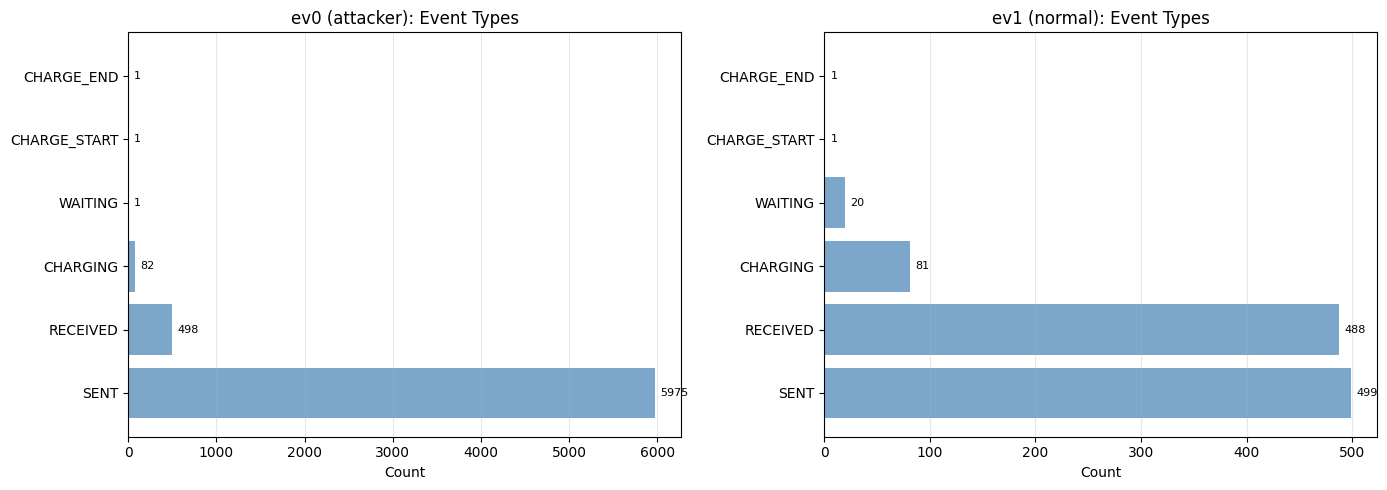

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, name, df in [(axes[0], 'ev0 (attacker)', ev0), (axes[1], 'ev1 (normal)', ev1)]:
    counts = df['event_type'].value_counts()
    bars = ax.barh(counts.index, counts.values, color='steelblue', alpha=0.7)
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_width() + max(counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                str(val), va='center', fontsize=8)
    ax.set_xlabel('Count')
    ax.set_title(f'{name}: Event Types')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Communication Type Breakdown

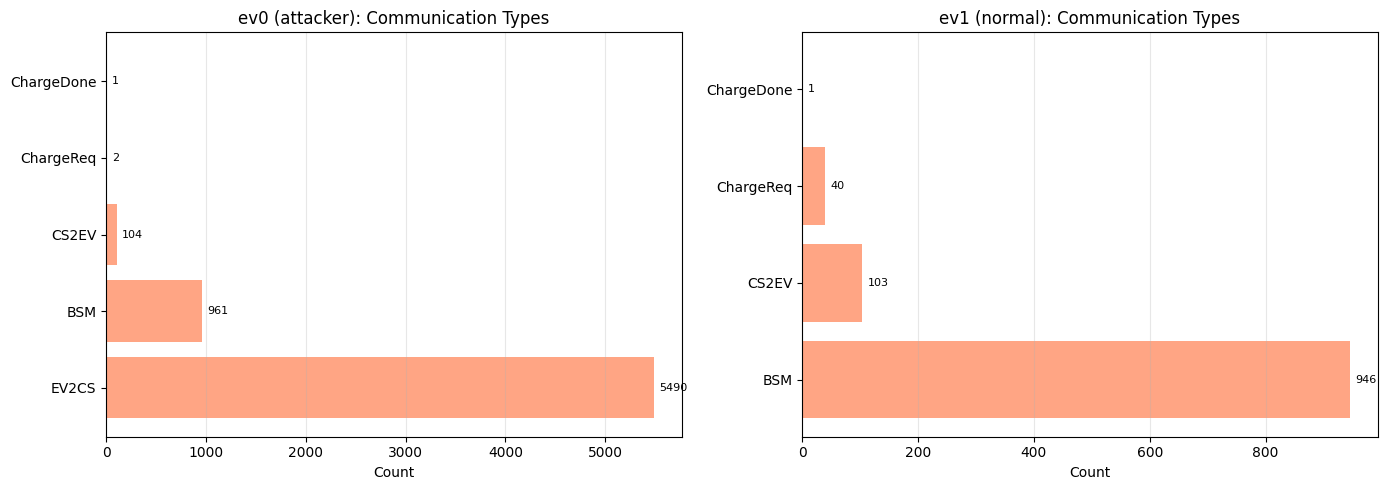

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, name, df in [(axes[0], 'ev0 (attacker)', ev0), (axes[1], 'ev1 (normal)', ev1)]:
    counts = df['communication_type'].value_counts()
    bars = ax.barh(counts.index, counts.values, color='coral', alpha=0.7)
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_width() + max(counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                str(val), va='center', fontsize=8)
    ax.set_xlabel('Count')
    ax.set_title(f'{name}: Communication Types')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Battery Level Over Time (with Charging)

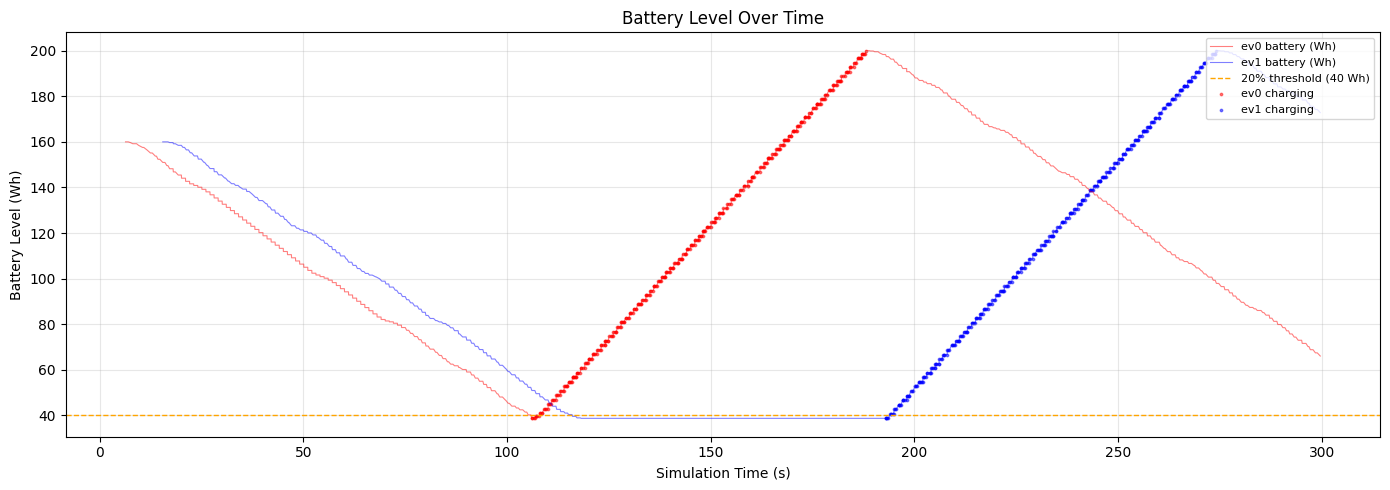

In [17]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(ev0.timestamp, ev0.battery_level, 'r-', alpha=0.5, linewidth=0.8, label='ev0 battery (Wh)')
ax.plot(ev1.timestamp, ev1.battery_level, 'b-', alpha=0.5, linewidth=0.8, label='ev1 battery (Wh)')

# Threshold line: 20% of 200 Wh = 40 Wh
ax.axhline(y=40, color='orange', linestyle='--', linewidth=1, label='20% threshold (40 Wh)')

# Mark charging
ev0_c = ev0[ev0['is_charging'] == 1]
if len(ev0_c) > 0:
    ax.scatter(ev0_c.timestamp, ev0_c.battery_level, color='red', s=3, alpha=0.5, label='ev0 charging')

ev1_c = ev1[ev1['is_charging'] == 1]
if len(ev1_c) > 0:
    ax.scatter(ev1_c.timestamp, ev1_c.battery_level, color='blue', s=3, alpha=0.5, label='ev1 charging')

ax.set_xlabel('Simulation Time (s)')
ax.set_ylabel('Battery Level (Wh)')
ax.set_title('Battery Level Over Time')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Diagnosis: Why ev1 Never Charges
ev1 sends many ChargeReqs but never transitions to `is_charging=1`.  
Let's check what responses ev1 received.

In [18]:
# ev1 received packets containing ChargeResp
ev1_resp = ev1[ev1['packet_name'].str.contains('ChargeResp', na=False)]
print(f"ev1 ChargeResp received: {len(ev1_resp)}")
if len(ev1_resp) > 0:
    available = ev1_resp[ev1_resp['packet_name'].str.contains('AVAILABLE')]
    busy = ev1_resp[ev1_resp['packet_name'].str.contains('BUSY')]
    print(f"  AVAILABLE: {len(available)}")
    print(f"  BUSY:      {len(busy)}")
    if len(busy) > 0:
        print(f"  First BUSY at t={busy.iloc[0].timestamp:.1f}s")
        print(f"  Last BUSY at  t={busy.iloc[-1].timestamp:.1f}s")
else:
    print("  ev1 never received any ChargeResp from CS!")

# When ev0 was charging (blocking the slot)
ev0_c = ev0[ev0['is_charging'] == 1]
if len(ev0_c) > 0:
    print(f"\nev0 occupied CS slot from t={ev0_c.timestamp.min():.1f}s to t={ev0_c.timestamp.max():.1f}s")
    print(f"  Duration: {ev0_c.timestamp.max() - ev0_c.timestamp.min():.0f}s")

# ev1 SoC when first ChargeReq was sent
ev1_req = ev1[ev1['communication_type'] == 'ChargeReq']
if len(ev1_req) > 0:
    first = ev1_req.iloc[0]
    print(f"\nev1 first ChargeReq: t={first.timestamp:.1f}s, SoC={first.soc:.4f}, dist_to_cs={first.dist_to_cs:.0f}m")
    print(f"ev1 sent {len(ev1_req)} ChargeReqs total")
    
    # Check ev1 speed during ChargeReq periods
    print(f"\nev1 speed during ChargeReqs:")
    print(f"  min speed:  {ev1_req.speed.min():.1f} m/s")
    print(f"  max speed:  {ev1_req.speed.max():.1f} m/s")
    print(f"  mean speed: {ev1_req.speed.mean():.1f} m/s")

ev1 ChargeResp received: 20
  AVAILABLE: 2
  BUSY:      18
  First BUSY at t=116.1s
  Last BUSY at  t=184.1s

ev0 occupied CS slot from t=106.1s to t=188.1s
  Duration: 82s

ev1 first ChargeReq: t=116.1s, SoC=0.1977, dist_to_cs=278m
ev1 sent 40 ChargeReqs total

ev1 speed during ChargeReqs:
  min speed:  0.0 m/s
  max speed:  9.0 m/s
  mean speed: 0.5 m/s


## 8. Root Cause Summary
Analyze the sequence of events to identify the exact root cause.

In [19]:
print("=" * 70)
print("ROOT CAUSE ANALYSIS")
print("=" * 70)

ev0_has_charging = (ev0['is_charging'] == 1).any()
ev1_has_charging = (ev1['is_charging'] == 1).any()

print(f"\nev0 (attacker) charged: {'YES' if ev0_has_charging else 'NO'}")
print(f"ev1 (normal)   charged: {'YES' if ev1_has_charging else 'NO'}")

if ev0_has_charging and not ev1_has_charging:
    print("\n--- DIAGNOSIS ---")
    print("ev0 charged successfully but ev1 did not.")
    print("\nReason: SLOT CONTENTION + NO WAIT BEHAVIOR")
    print("")
    print("1. ev0 reaches 20% SoC first (departs earlier, drives faster initially)")
    print("2. ev0 sends ChargeReq -> CS responds AVAILABLE -> ev0 begins charging")
    print("3. ev0 STOPS at CS (speed=0), slot occupied (maxSlots=1)")
    print("4. ev1 reaches 20% SoC while ev0 is still charging")
    print("5. ev1 sends ChargeReq -> CS responds BUSY")
    print("6. BUG: ev1 KEEPS DRIVING (does not stop to wait for slot)")
    print("7. ev1 drives out of CS range (>300m)")
    print("8. ev1 loops back near CS, retries, gets BUSY again")
    print("9. Battery drains to 0 while constantly retrying and driving")
    print("")
    print("FIX NEEDED: EV must STOP near CS when SoC<20% and WAIT for slot,")
    print("            even if CS responds BUSY. Only resume after fully charged.")

elif not ev0_has_charging and not ev1_has_charging:
    ev0_min_soc = ev0.soc.min()
    ev1_min_soc = ev1.soc.min()
    print("\n--- DIAGNOSIS ---")
    print("Neither EV ever charged.")
    print(f"ev0 min SoC: {ev0_min_soc:.4f} ({ev0_min_soc*100:.1f}%)")
    print(f"ev1 min SoC: {ev1_min_soc:.4f} ({ev1_min_soc*100:.1f}%)")
    if ev0_min_soc > 0.2 and ev1_min_soc > 0.2:
        print("\nReason: SoC never dropped below 20% threshold.")
        print("FIX: Increase energyPerMeter (e.g. 0.1 Wh/m) or extend routes.")
    else:
        ev0_req_count = len(ev0[ev0['communication_type'] == 'ChargeReq'])
        ev1_req_count = len(ev1[ev1['communication_type'] == 'ChargeReq'])
        print(f"\nChargeReq count: ev0={ev0_req_count}, ev1={ev1_req_count}")
        if ev0_req_count == 0 and ev1_req_count == 0:
            print("Reason: No ChargeReq sent despite low SoC.")
            print("FIX: Check getNodePosition/distanceTo or chargingRange settings.")
        else:
            print("Reason: ChargeReq sent but no AVAILABLE response received.")
            print("FIX: Check CS app, multicast delivery, or slot availability.")

print("\n" + "=" * 70)

ROOT CAUSE ANALYSIS

ev0 (attacker) charged: YES
ev1 (normal)   charged: YES



## 9. CS Activity: ChargeReq/ChargeResp Events

In [20]:
# CS received ChargeReq and sent ChargeResp
cs_req = cs0[cs0['communication_type'].str.contains('ChargeReq', na=False)]
cs_resp = cs0[cs0['communication_type'].str.contains('ChargeResp', na=False)]
cs_done = cs0[cs0['communication_type'].str.contains('ChargeDone', na=False)]

print(f"CS received ChargeReq: {len(cs_req)}")
print(f"CS sent ChargeResp:    {len(cs_resp)}")
print(f"CS received ChargeDone: {len(cs_done)}")

# Show first few CS charging events
cs_charging_events = cs0[cs0['communication_type'].isin(['ChargeReq', 'ChargeResp', 'ChargeDone'])]
if len(cs_charging_events) > 0:
    print(f"\nFirst 10 CS charging protocol events:")
    print(cs_charging_events[['timestamp', 'event_type', 'communication_type',
                               'packet_name', 'source_address']].head(10).to_string(index=False))
else:
    print("\nNo charging protocol events found in CS log.")

CS received ChargeReq: 20
CS sent ChargeResp:    20
CS received ChargeDone: 2

First 10 CS charging protocol events:
 timestamp event_type communication_type                packet_name source_address
106.100082   RECEIVED          ChargeReq    ChargeReq-ev[0]-soc0.19     10.0.0.157
106.100082       SENT         ChargeResp ChargeResp-AVAILABLE-ev[0]          cs[0]
116.100083   RECEIVED          ChargeReq    ChargeReq-ev[1]-soc0.20     10.0.0.218
116.100083       SENT         ChargeResp      ChargeResp-BUSY-ev[1]          cs[0]
120.100083   RECEIVED          ChargeReq    ChargeReq-ev[1]-soc0.19     10.0.0.218
120.100083       SENT         ChargeResp      ChargeResp-BUSY-ev[1]          cs[0]
124.100083   RECEIVED          ChargeReq    ChargeReq-ev[1]-soc0.19     10.0.0.218
124.100083       SENT         ChargeResp      ChargeResp-BUSY-ev[1]          cs[0]
128.100083   RECEIVED          ChargeReq    ChargeReq-ev[1]-soc0.19     10.0.0.218
128.100083       SENT         ChargeResp      ChargeR

## 10. CS Battery Level and Energy Delivery
Track the CS battery over time, including energy delivered to EVs and grid recharge.

In [ ]:
# CS battery analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: CS battery level over time
ax1 = axes[0]
ax1.plot(cs0.timestamp, cs0.battery_level, 'g-', linewidth=0.8, alpha=0.7)
ax1.set_ylabel('CS Battery (Wh)')
ax1.set_title('CS Battery Level Over Time')
ax1.grid(True, alpha=0.3)

# Plot 2: CS SoC over time
ax2 = axes[1]
ax2.plot(cs0.timestamp, cs0.soc * 100, 'g-', linewidth=0.8, alpha=0.7)
ax2.set_ylabel('CS SoC (%)')
ax2.set_title('CS State of Charge Over Time')
ax2.grid(True, alpha=0.3)

# Plot 3: Energy delivered (cumulative) from energy_consumption column
ax3 = axes[2]
ax3.plot(cs0.timestamp, cs0.energy_consumption, 'm-', linewidth=0.8, alpha=0.7)
ax3.set_ylabel('Cumulative Energy (Wh)')
ax3.set_title('Cumulative Energy Delivered to EVs')
ax3.set_xlabel('Simulation Time (s)')
ax3.grid(True, alpha=0.3)

# Mark charging periods (CS_DISCHARGING events)
cs_discharging = cs0[cs0['event_type'] == 'CS_DISCHARGING']
if len(cs_discharging) > 0:
    for ax in axes:
        ax.axvspan(cs_discharging.timestamp.min(), cs_discharging.timestamp.max(),
                   alpha=0.1, color='red', label='CS actively charging EV')
    axes[0].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Summary stats
print(f"CS battery range: [{cs0.battery_level.min():.1f}, {cs0.battery_level.max():.1f}] Wh")
print(f"CS SoC range:     [{cs0.soc.min()*100:.1f}%, {cs0.soc.max()*100:.1f}%]")
print(f"CS_IDLE events:        {len(cs0[cs0['event_type'] == 'CS_IDLE'])}")
print(f"CS_DISCHARGING events: {len(cs_discharging)}")
print(f"Max energy delivered:  {cs0.energy_consumption.max():.2f} Wh")